<a href="https://colab.research.google.com/github/coderanandmaurya/Campaign_for_selling_personal_loans/blob/main/Campaign_for_selling_personal_loan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import model_selection
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
warnings.filterwarnings('ignore')

# Import the data

In [487]:
url = "https://raw.githubusercontent.com/coderanandmaurya/Campaign_for_selling_personal_loans/main/Bank_Personal_Loan_Modelling%20(1).csv"
df = pd.read_csv(url, encoding="unicode_escape")
df.head() ##this returns the first five rows of the dataset

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


# Column descriptions				


- binary category variable:

  - Personal Loan	: Did this customer accept the personal loan offered in the last campaign?
  - Securities Account : Does the customer have a securities account with the bank?
  - CD Account	: Does the customer have a certificate of deposit (CD) account with the bank?	
  - Online - Does the customer use internet banking facilities?
  - CreditCard :	Does the customer use a credit card issued by UniversalBank?

- Interval Variable:
  - Age	: Customer's age in completed years
  - Experience	: years of professional experience
  - Income	: Annual income of the customer in dollar
  - CCAvg : spending on credit cards pr month in dollar
  - Mortgage :	Value of house mortgage if any in dollar

- Ordinal Categorical Variables are:
  - Family - Family size of the customer
  - Education :	Education Level. 1: Undergrad; 2: Graduate; 3: Advanced/Professional

- The nominal variable is :
  - ID	: Customer ID		
  - Zip Code

# EDA

In [488]:
df.shape

(5000, 14)

In [489]:
df.dtypes

ID                      int64
Age                     int64
Experience              int64
Income                  int64
ZIP Code                int64
Family                  int64
CCAvg                 float64
Education               int64
Mortgage                int64
Personal Loan           int64
Securities Account      int64
CD Account              int64
Online                  int64
CreditCard              int64
dtype: object

In [490]:
df.isnull().sum() ##check for null values

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

In [491]:
df.duplicated().any() ##check for duplicate values

False

In [492]:
#There are -ve numbmers in experience! lets change into +ve. 
df = df.abs() # Convert to non-negative using .abs function
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,5000.0,2500.500000,1443.520003,1.0,1250.75,2500.5,3750.25,5000.0
Age,5000.0,45.338400,11.463166,23.0,35.00,45.0,55.00,67.0
Experience,5000.0,20.134600,11.415189,0.0,10.00,20.0,30.00,43.0
Income,5000.0,73.774200,46.033729,8.0,39.00,64.0,98.00,224.0
ZIP Code,5000.0,93152.503000,2121.852197,9307.0,91911.00,93437.0,94608.00,96651.0
Family,5000.0,2.396400,1.147663,1.0,1.00,2.0,3.00,4.0
CCAvg,5000.0,1.937938,1.747659,0.0,0.70,1.5,2.50,10.0
Education,5000.0,1.881000,0.839869,1.0,1.00,2.0,3.00,3.0
Mortgage,5000.0,56.498800,101.713802,0.0,0.00,0.0,101.00,635.0
Personal Loan,5000.0,0.096000,0.294621,0.0,0.00,0.0,0.00,1.0


# Observation

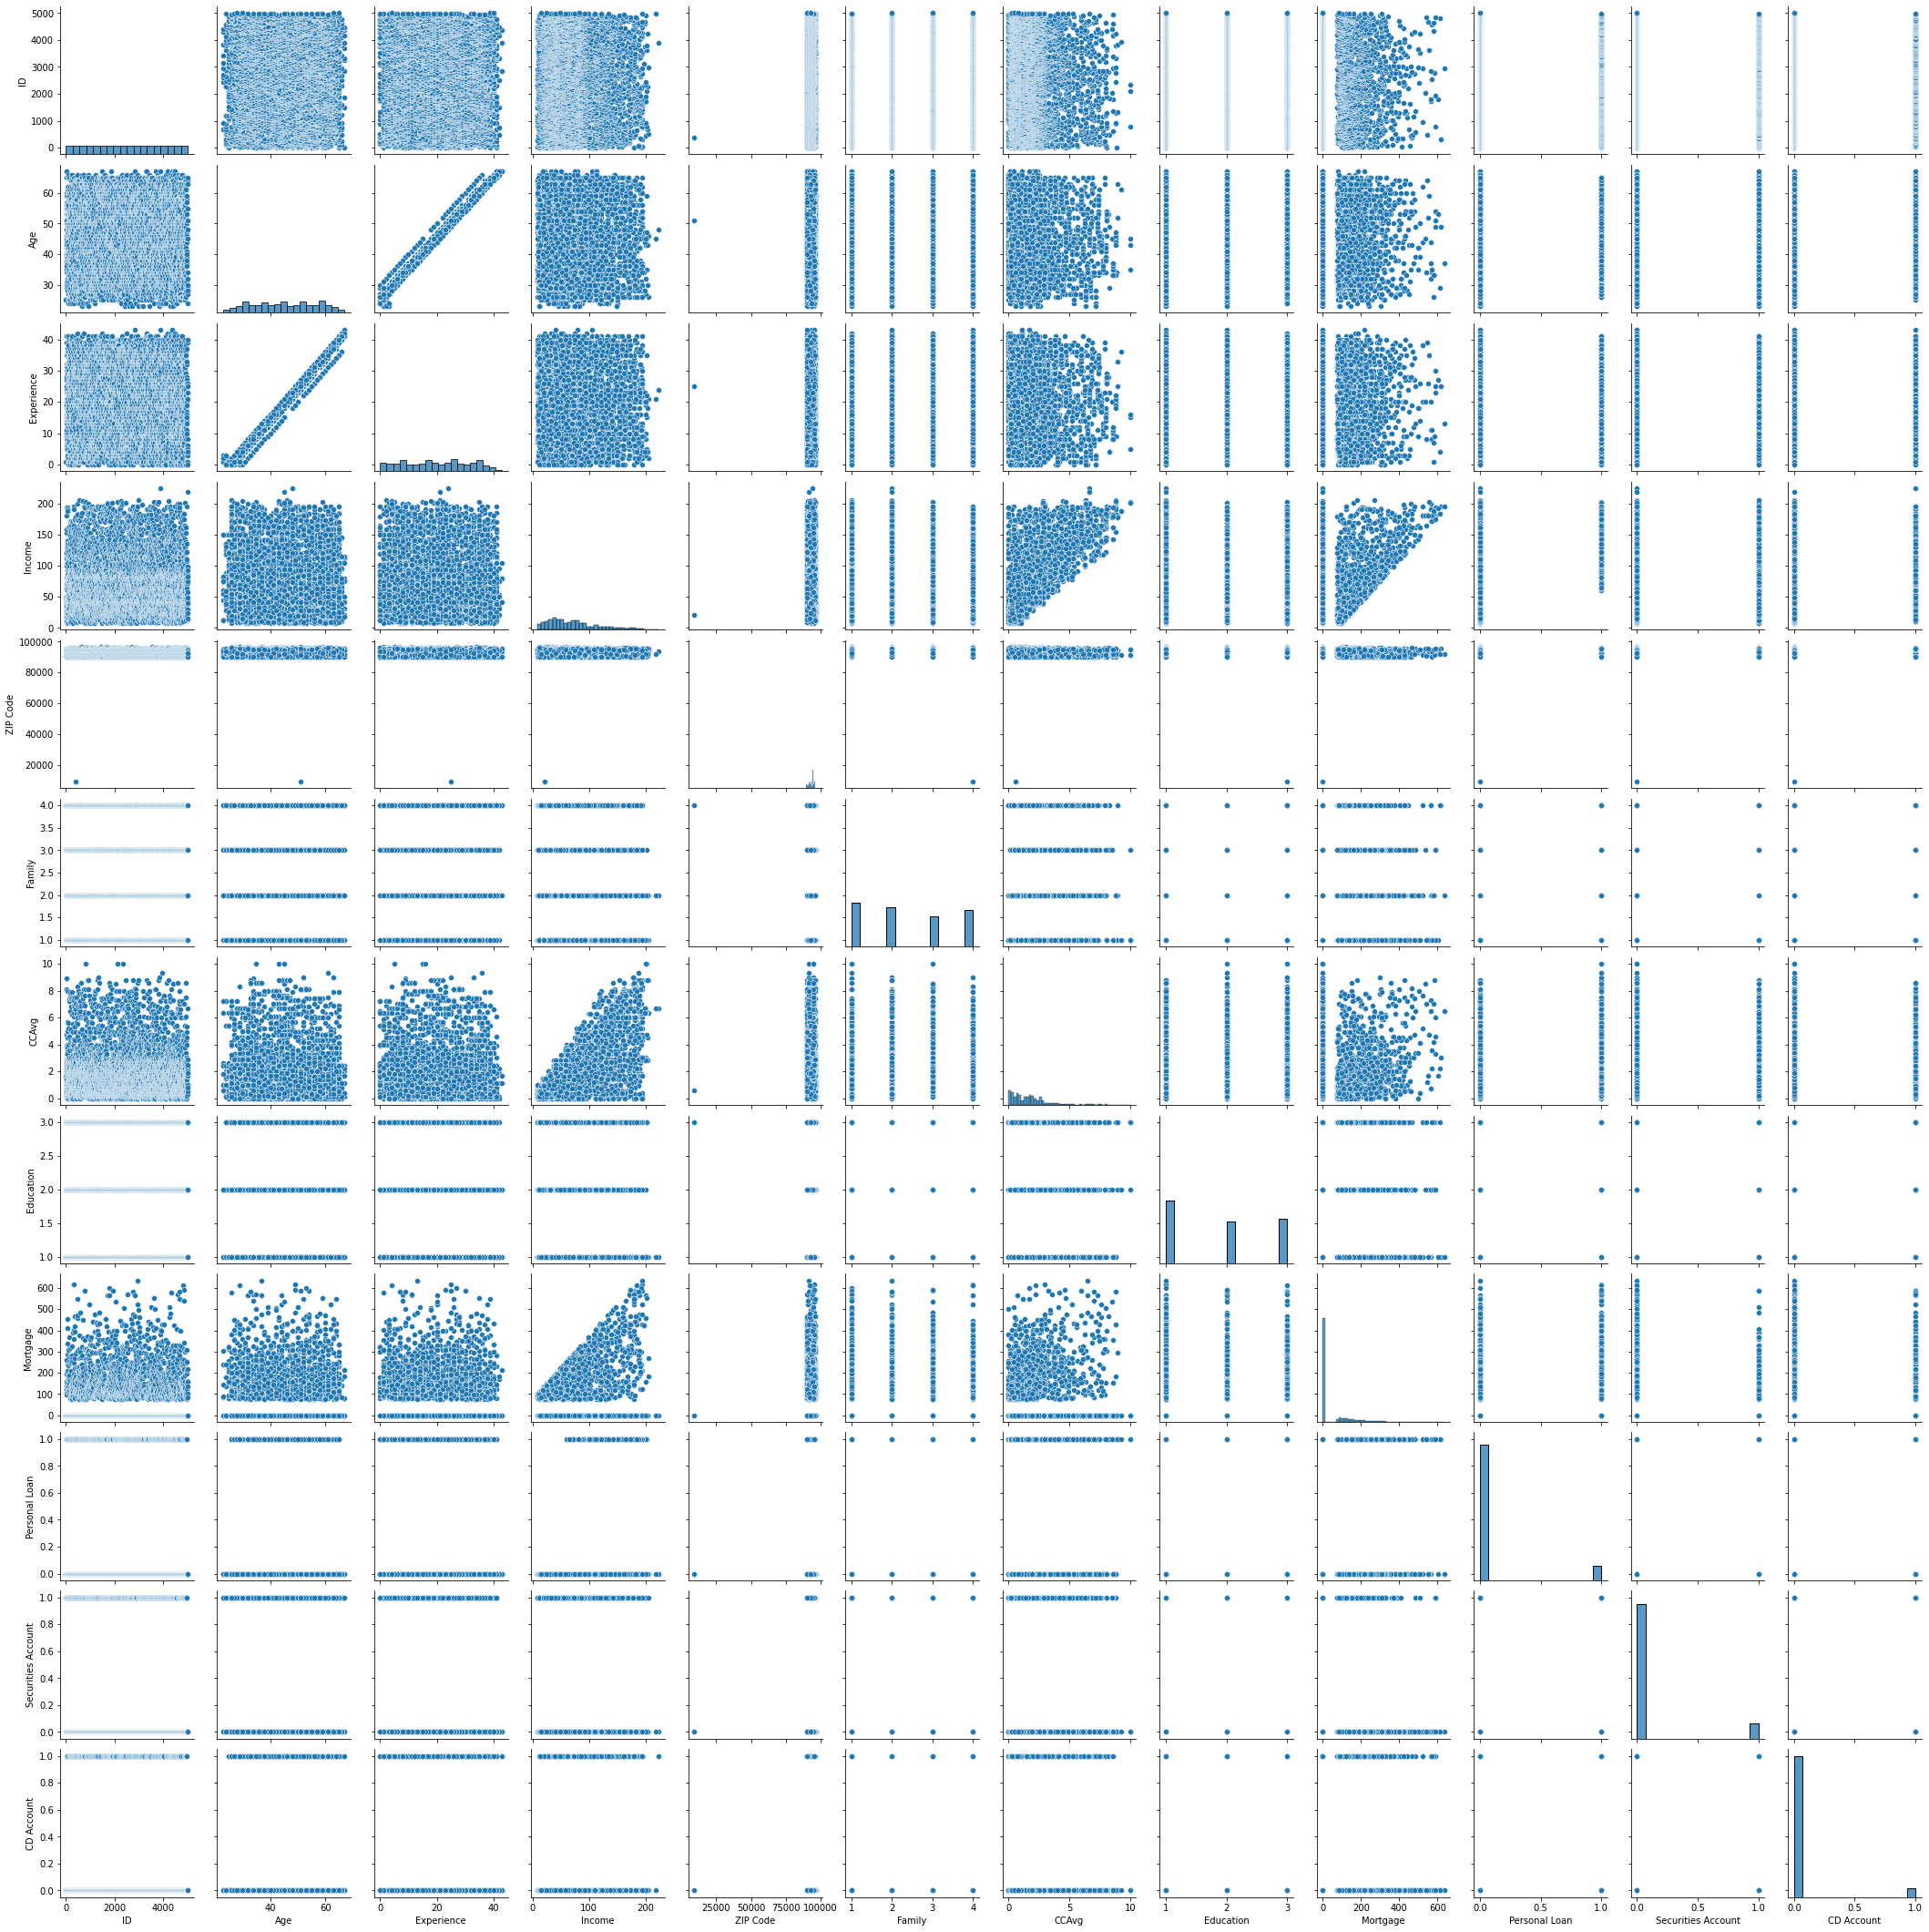

In [493]:
df_attr = df.iloc[:,0:12] #compare all attributes visually to check for relationships that can be exploited
sns.pairplot(df_attr)

- Age and experience have strong positive relation
- Age and income have no linear relationship
- Age and experience have no linear relationship

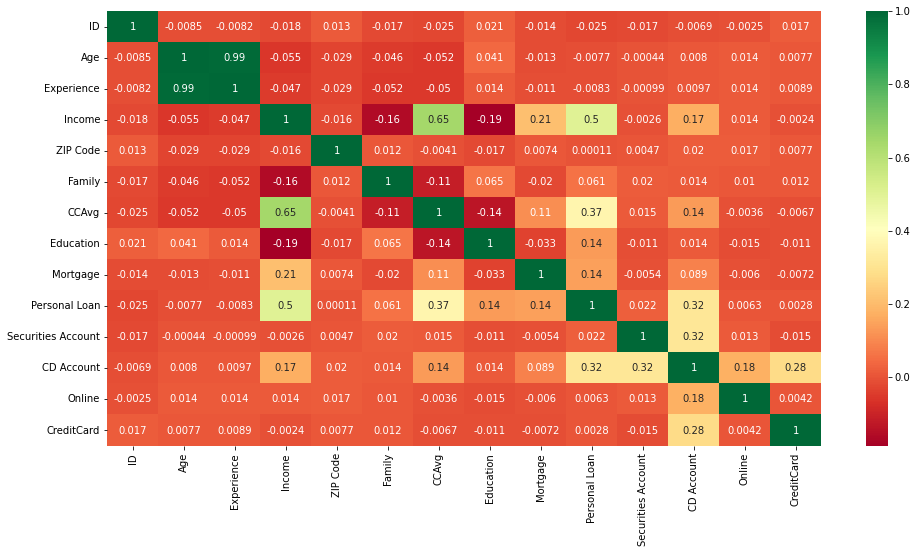

In [494]:
# Correlation with heat map
plt.figure(figsize=[16,8])
corr = sns.heatmap(df.corr(), annot=True, cmap="RdYlGn")

- Observation

  - Income and CCAvg is moderately correlated.
  - Age and Experience is highly correlated

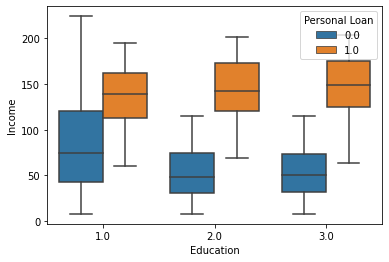

In [495]:
sns.boxplot(x='Education',y='Income',hue='Personal Loan',data=df)

- Observation : It seems the customers whose education level is 1 is having more income. However customers who has taken the personal loan have the same income levels

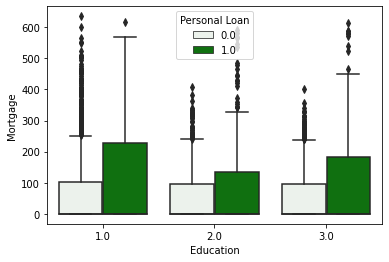

In [496]:
sns.boxplot(x="Education", y='Mortgage', hue="Personal Loan", data=df,color='green')

- Observation : From the above chart it seems that customer who do not have personal loan and customer who has personal loan have high mortgage

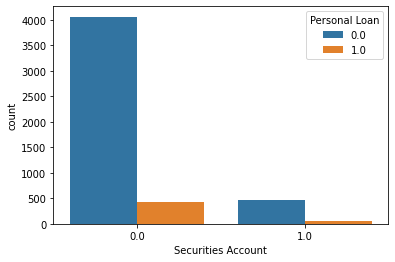

In [497]:
sns.countplot(x="Securities Account", data=df,hue="Personal Loan")

- Observation : Majority of customers who does not have loan have securities account

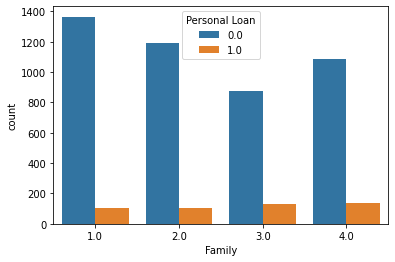

In [498]:
sns.countplot(x='Family',data=df,hue='Personal Loan')

- Observation: Family size does not have any impact in personal loan. But it seems families with size of 3 are more likely to take loan. When considering future campaign this might be good association.

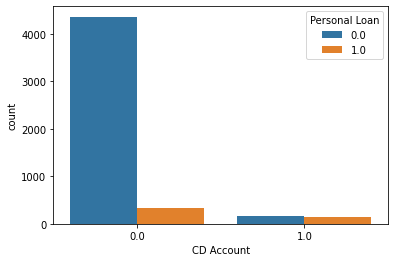

In [499]:
sns.countplot(x='CD Account',data=df,hue='Personal Loan')


- Observation: Customers who does not have CD account , does not have loan as well. This seems to be majority. But almost all customers who has CD account has loan as well

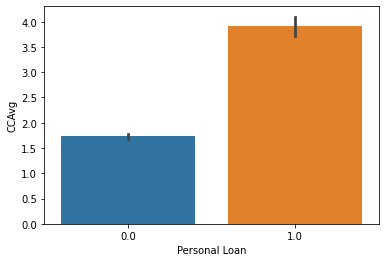

In [500]:
sns.barplot(y="CCAvg",x="Personal Loan", data=df)

- Observation: The graph show persons who have personal loan have a higher credit card average. 

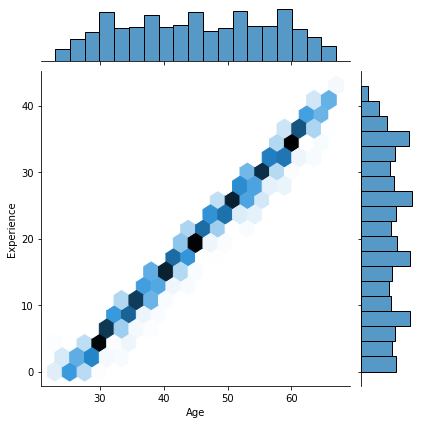

In [501]:
sns.jointplot(x='Age',y='Experience',data=df,kind='hex')

- Observation The above plot show with experience and age have a positive correlation. As experience increase age also increases. Also the colors show the education level. There is gap in the mid forties of age and also more people in the under graduate level

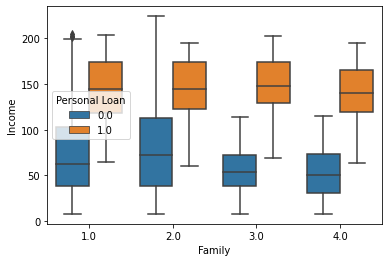

In [502]:
sns.boxplot(x="Family", y="Income", hue="Personal Loan",data=df)

Observation: the graph shos us families with income less than 100K are less likely to take loan,than families with high income

# Splitting the Train and Test df

In [503]:
X_df = df.loc[:, df.columns != 'Personal Loan'] # Separate the independent attributes and store them in X array
y_df = df.loc[:, df.columns == 'Personal Loan'] # Store the target column (column 8) into Y array

# Logistic Regression

- MODEL PREPARATION

In [504]:
# Create the training and test data set in the ratio of 70:30 respectively
# Prepare data for logistic regression
features=X_df.iloc[:, 1:10]
features_array = features.values   #logistic modeling algorithm requires feature array not dfframe
target_labels = y_df.values

test_size = 0.30 # taking 70:30 training and test set
seed = 100  # Random numbmer seeding for reapeatability of the code when using random functions to 
# generate the training and test df

X_train, X_test, y_train, y_test = model_selection.train_test_split(features_array, target_labels, test_size=test_size, random_state=seed)
y_train = np.ravel(y_train)   # to convert 1 d vector into 1 d array

- MODEL SELECTION

In [505]:
# Let us first try logistic regression to predict the personal loan affinity - 
# We removed the binned columns for this (considered only 11 columns 1:10) which are numeric
model = LogisticRegression()
model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
y_predict = model.predict(X_test)
print(model_score)
print(metrics.confusion_matrix(y_test, y_predict))

0.9
[[1304   38]
 [ 112   46]]


In [506]:
# The accuracy score of .954 looks impressive but do not forget, it is unreliable as it is a score at
# model level. Let us look at class level, especially the class 1.
# summarize the fit of the model
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.92      0.97      0.95      1342
         1.0       0.55      0.29      0.38       158

    accuracy                           0.90      1500
   macro avg       0.73      0.63      0.66      1500
weighted avg       0.88      0.90      0.89      1500



In [507]:
#The precision and recall for class 1 is low...

#Precision: Within a given set of positively-labeled results, the fraction that were 
#true positives = tp/(tp + fp) , this has to be calculated for each class i.e. 0 and 1 and should be
# high for the class less represented, class 1 in our example

#Recall: Given a set of positively-labeled results, the fraction of all positives that were 
#retrieved = tp/(tp + fn)

# Accuracy: tp + tn / (tp + tn + fp +fn) But this measure can be dominated by larger class. 
# Suppose 10, 90 and 80 of 90 is correctly predicted while only 2 of 0 is predicted correctly. 
# Accuracy is 80+2 / 100 i.e. 82%

# F is harmonic mean of precision and recal given by ((B^2 +1) PR) / (B^2P +R)
#When B is set to 1 we get F1 = 2PR / (P+R)

# Naive Bayes Model

- MODEL PREPARATION

In [508]:
# Create the training and test data set in the ratio of 70:30 respectively. Can be any other ratio...
# Prepare data for logistic regression

features=X_df.iloc[:, 1:10]
target_labels = df.loc[:, df.columns == 'Personal Loan']

X_array = features.values
y_array = target_labels.values

test_size = 0.30 # taking 70:30 training and test set
seed = 100  # Random numbmer seeding for reapeatability of the code

X_train, X_test, y_train, y_test = model_selection.train_test_split(X_array, y_array, test_size=test_size, random_state=seed)
y_train = np.ravel(y_train)   # to convert 1 d vector into 1 d array

- MODEL SELECTION

In [509]:
# Invoking the NB Gaussian function to create the model
# fitting the model in the training data set
model = GaussianNB()
model.fit(X_train, y_train)
model_score = model.score(X_test, y_test)
y_predict = model.predict(X_test)
print(model_score)
predictions=model.predict(X_test)

#Assess the accuracy of the model on test data
print(metrics.confusion_matrix(y_test,predictions))

0.8993333333333333
[[1250   92]
 [  59   99]]


In [510]:
# make predictions
expected = y_test
predicted = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1342
         1.0       0.52      0.63      0.57       158

    accuracy                           0.90      1500
   macro avg       0.74      0.78      0.76      1500
weighted avg       0.91      0.90      0.90      1500



# K Nearest Neighbours

- MODEL SELECTION

In [511]:
from sklearn.neighbors import KNeighborsClassifier
NNH = KNeighborsClassifier(n_neighbors= 3 , weights = 'distance')
NNH.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [512]:
predicted_labels = NNH.predict(X_test)

In [513]:
model_score = model.score(X_test, y_test)
print(metrics.confusion_matrix(y_test, predicted_labels))

[[1281   61]
 [ 114   44]]


In [514]:
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94      1342
         1.0       0.42      0.28      0.33       158

    accuracy                           0.88      1500
   macro avg       0.67      0.62      0.64      1500
weighted avg       0.87      0.88      0.87      1500



#### Recall (true positives / (true positives + false negatives)) for class 1 is the least. That is because majority of data points belong to class 0 and in KNN, probability of finding data points from class 0 closer to a test point than a data point from class 1 is high.

In [515]:
### let us check the effect of scaling (convert all dimensions to z scores)
from sklearn import preprocessing
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)
NNH.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [516]:
predicted_labels = NNH.predict(X_test_scaled)

In [517]:
y_predict = model.predict(X_test)
print(metrics.confusion_matrix(y_test, predicted_labels))

[[1339    3]
 [  72   86]]


In [518]:
# summarize the fit of the model
print(metrics.classification_report(y_test, predicted_labels))

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97      1342
         1.0       0.97      0.54      0.70       158

    accuracy                           0.95      1500
   macro avg       0.96      0.77      0.83      1500
weighted avg       0.95      0.95      0.94      1500



# DECISSION TREE CLASSIFIER


In [519]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dt_model=DecisionTreeClassifier(criterion = 'entropy',max_depth=3)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [520]:
y_predict = dt_model.predict(X_test)

In [521]:
model_score = model.score(X_test, y_test)
y_predict = model.predict(X_test)
print(metrics.confusion_matrix(y_test, y_predict))

[[1250   92]
 [  59   99]]


In [522]:
print(metrics.classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1342
         1.0       0.52      0.63      0.57       158

    accuracy                           0.90      1500
   macro avg       0.74      0.78      0.76      1500
weighted avg       0.91      0.90      0.90      1500



## Random Forest classifier

In [523]:
randomforest_model = RandomForestClassifier(max_depth=2, random_state=0)
randomforest_model.fit(train_set, train_labels)

RandomForestClassifier(max_depth=2, random_state=0)

In [524]:
predicted_random=randomforest_model.predict(test_set)
randomforest_model.score(test_set,test_labels)

0.904

In [525]:
print(metrics.confusion_matrix(y_test,predictions))

[[1250   92]
 [  59   99]]


In [526]:
# summarize the fit of the model
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.95      0.93      0.94      1342
         1.0       0.52      0.63      0.57       158

    accuracy                           0.90      1500
   macro avg       0.74      0.78      0.76      1500
weighted avg       0.91      0.90      0.90      1500



# compare


LR: 0.919000 (0.017487)
KNN: 0.902000 (0.010159)
CART: 0.980800 (0.005879)
NB: 0.886600 (0.011351)
RF: 0.986600 (0.003105)


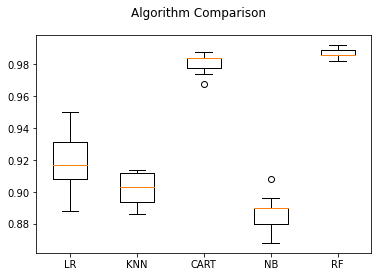

In [527]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10,shuffle=True, random_state=seed)
	cv_results = model_selection.cross_val_score(model, X_df, y_df, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()